# Logistic Regression with L1 regularization for sparse recovery of the dysregulated pathways in our synthetic datasets

In [1]:
%pylab inline
import pickle
import pandas as pd
# import networkx as nx
from matplotlib_venn import venn3, venn3_circles, venn2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split, cross_val_score, KFold

repo_path = '/Users/alex/Documents/gslr/'
data_path = repo_path + 'experiments/generated_data/3/'
KEGG_path = repo_path + 'experiments/KEGG/KEGG_df.filtered.with_correlates.pickle'
interactome_path = repo_path + 'experiments/algorithms/pcsf/inbiomap_temp.tsv'
pathway_id = 'hsa04110'

Populating the interactive namespace from numpy and matplotlib


### I. Load Dataset

In [2]:
dataset = pd.read_csv(data_path + pathway_id + '_inbiomap_exp.csv', index_col=0)
dataset.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa04110,0.0,0.115272,-0.365345,-0.014955,-0.374350,0.109953,-0.0,-0.313725,0.034973,-0.309654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,-0.138520,-0.340004,0.430427,0.618810,-0.400398,-0.0,0.281479,-0.903482,0.312078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.492418,0.612346,0.544840,-0.253648,-0.004268,-0.0,-0.109864,0.337787,-0.604446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,-0.592521,0.050179,0.383061,0.261450,-0.131206,0.0,-0.265055,0.179607,-0.416877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,0.0,0.000973,0.040952,-0.728286,-0.604990,-0.119933,-0.0,-0.047649,0.165359,-0.616325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### II. Extract Labels

In [3]:
labels = dataset.index.values
labels

array(['hsa04110', 'hsa04110', 'negative', 'hsa04110', 'hsa04110',
       'negative', 'hsa04110', 'hsa04110', 'negative', 'hsa04110',
       'negative', 'hsa04110', 'hsa04110', 'negative', 'negative',
       'hsa04110', 'hsa04110', 'negative', 'negative', 'negative',
       'hsa04110', 'hsa04110', 'negative', 'hsa04110', 'hsa04110',
       'hsa04110', 'hsa04110', 'negative', 'hsa04110', 'negative',
       'hsa04110', 'hsa04110', 'hsa04110', 'hsa04110', 'negative',
       'hsa04110', 'hsa04110', 'hsa04110', 'hsa04110', 'hsa04110',
       'negative', 'negative', 'hsa04110', 'negative', 'negative',
       'negative', 'hsa04110', 'hsa04110', 'hsa04110', 'hsa04110',
       'hsa04110', 'negative', 'hsa04110', 'negative', 'hsa04110',
       'negative', 'negative', 'hsa04110', 'negative', 'hsa04110',
       'hsa04110', 'hsa04110', 'negative', 'hsa04110', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negati

### III. L1-regularized Sparse Logistic Regression

In [4]:
classifier = LogisticRegression(solver='liblinear', penalty='l1', C=100)
classifier = classifier.fit(dataset.values, labels)
coefs = pd.DataFrame(classifier.coef_, columns=dataset.columns)
features = coefs.ix[0, coefs.loc[0].nonzero()[0].tolist()].index.tolist()

/Users/alex/Documents/gslr/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


### IV. Examine Results

In [5]:
classifier.classes_

array(['hsa04110', 'negative'], dtype=object)

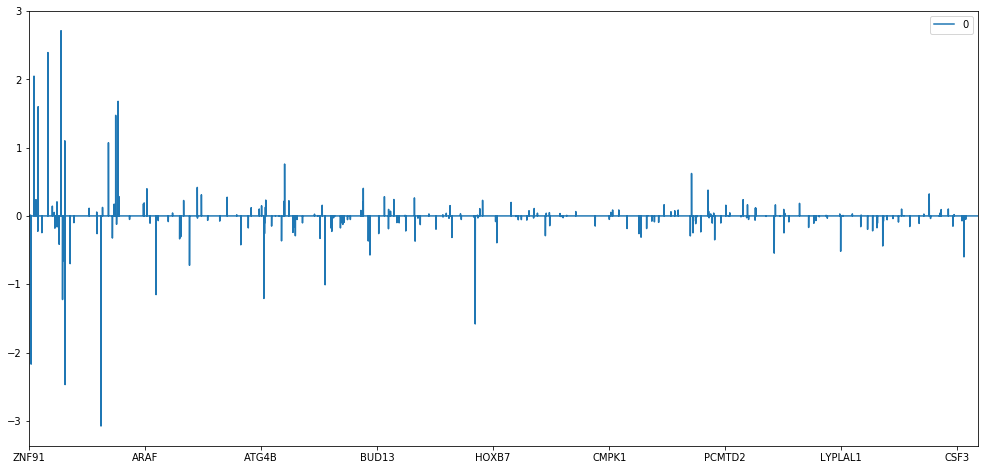

In [6]:
pd.DataFrame(classifier.coef_, columns=dataset.columns).transpose().plot(figsize=(17,8))

/Users/alex/Documents/gslr/venv/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


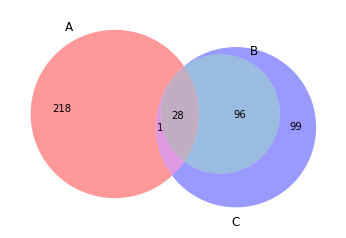

In [7]:
pathways_df = pd.read_pickle(KEGG_path)
genes, correlates = pathways_df.loc[pd.IndexSlice[:, :, [pathway_id]],['genes', 'correlates']].values[0]
correlates = correlates.tolist()
venn3([set(features), set(genes), set(genes)|set(correlates)])

### V. Ludwig's Softmax Loss experiments

In [8]:
def softmax_loss(X, y, W):
    # TODO: make this work with nopython=True
    assert len(X.shape) == 2
    n, d = X.shape
    assert y.shape == (n,)
    assert len(W.shape) == 2
    assert W.shape[1] == d
    c = W.shape[0]
    # TODO: check that elements in y are in the correct range
    
    # TODO: replace with transpose_b=True ?
    prod = np.dot(X, W.transpose())
    row_max = np.amax(prod, axis=1)
    prod_normalized = prod - np.expand_dims(row_max, 1)
    exp_prod = np.exp(prod_normalized)
    denom = np.sum(exp_prod, axis=1)
    
    total_loss = 0.0
    for ii in range(n):
        cur_y = y[ii]
        cur_x = X[ii,:]
        total_loss += prod_normalized[ii, cur_y] - math.log(denom[ii])
    return -total_loss / n

In [9]:
labeler = LabelEncoder()
labeler.fit(labels)
labels = labeler.transform(dataset.index.tolist())
y = labels
y

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [10]:
softmax_loss(dataset.values, y, np.vstack([-coefs.values, coefs.values]))

1.4606295572578938e-06